# RAG vs CAG

Для експерименту необхідний інстанс який має до 16Гб VRAM. 

Перед початком потрібно мати акаунт в HF та створити запит на використання моделі своїм аккантом: https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct

В поле нижче вставьте свій HF токен, який ви можете отримати за посиланням: https://huggingface.co/settings/tokens

In [1]:
from huggingface_hub import login

login()

In [2]:
import time
import random

import numpy as np
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    BitsAndBytesConfig,
    set_seed
)

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

# Set deterministic GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
hf_model_id = "meta-llama/Llama-3.1-8B-Instruct"

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,  # Enable double quantization
    bnb_4bit_compute_dtype=torch.bfloat16  # Set compute dtype to float16
)
model_4bit = AutoModelForCausalLM.from_pretrained(
    hf_model_id,
    quantization_config=quantization_config,
    device_map=device,
)
tokenizer = AutoTokenizer.from_pretrained(hf_model_id, device_map=device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Параметризація моделі

Я використав семплінг через те що без нього результати генерації з контекстом та RAG повертали пусті значення.

In [4]:
generation_config, unused_kwargs = GenerationConfig.from_pretrained(
    hf_model_id,
    return_unused_kwargs=True,
    do_sample=True,
    temperature=0.1,
    max_new_tokens=200,
    pad_token_id=tokenizer.eos_token_id
)
model_4bit.generation_config = generation_config

Ініціалізація шаблону чату для LLAMA моделі

In [5]:
chat_template = """{% if messages[0]['role'] == 'system' %}
    {% set offset = 1 %}
{% else %}
    {% set offset = 0 %}
{% endif %}

{{ bos_token }}
{% for message in messages %}
    {% if (message['role'] == 'user') != (loop.index0 % 2 == offset) %}
        {{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}
    {% endif %}

    {{ '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}
{% endfor %}

{% if add_generation_prompt %}
    {{ '<|start_header_id|>' + 'assistant' + '<|end_header_id|>\n\n' }}
{% endif %}
"""

tokenizer.chat_template = chat_template

## Генерація без використання контексту

In [6]:
def get_input_tokens(tokenizer, chat: list[dict]) -> dict:
    """
    Converts a list of chat messages into input tokens suitable for a HuggingFace model.

    This function applies the tokenizer's chat template to a chat conversation,
    tokenizes the input, and returns a dictionary containing input tensors
    (e.g., input_ids, attention_mask) for model inference.

    Args:
        tokenizer: HuggingFace tokenizer with a defined chat template.
        chat: Conversation represented as a list of message dicts,
            where each dict has 'role' (e.g., 'system', 'user') and 'content' (str).

    Returns:
        Dictionary of model-ready input tensors, such as 'input_ids' and 'attention_mask'.
    """
    return tokenizer.apply_chat_template(
        chat,
        tokenize=True,
        return_dict=True,
        continue_final_message=True,
        return_tensors='pt'
    )


def generate_completion(model, tokenizer, chat: list[dict]) -> tuple[str, int]:
    """
    Generates text with sampling and applied chat-template.

     Args:
        model: HuggingFace model
        tokenizer: HuggingFace tokenizer
        chat: list of system and user's prompts

    Returns:
        Generated completion with number of input tokens.
    """
    input_tokens = get_input_tokens(tokenizer, chat)
    input_tokens.to(device)
    outputs = model.generate(**input_tokens)
    input_length = input_tokens.input_ids.shape[1]
    generated_tokens = outputs[0, input_length:]
    generated_answer = tokenizer.decode(generated_tokens, special_tokens=False)
    return generated_answer, input_tokens["input_ids"].shape[-1]


SYSTEM_PROMPT = """
You are an experienced pop culture observer who is eager to help others learn about pop culture.
Answer questions with a concise response or just a few sentences. Answer in Ukrainian language.
"""

chat = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": "Who is Stepan Giga?"},
]
generated_text, n_tokens = generate_completion(model_4bit, tokenizer, chat)
print(f"Кількість вхідних токенів: {n_tokens}")
print(generated_text)

Кількість вхідних токенів: 57
<|eot_id|>


## Генерація з контекстом

Контекст був створений на базі офіційної сторінки вікіпедії про [Степана Гігу](https://uk.wikipedia.org/wiki/%D0%93%D1%96%D0%B3%D0%B0_%D0%A1%D1%82%D0%B5%D0%BF%D0%B0%D0%BD_%D0%9F%D0%B5%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%87), та попередньою обробкою через ChatGPT.

### Інформація з вікіпедії про Степана Гігу

In [7]:
with open("stepan_giga_summary_full.md", mode="r") as file:
    giga_summary = file.read()
    giga_summary = giga_summary.replace("\xa0", "")
print(giga_summary)

Гіга Степан Петрович (іноді Ґіґа , 16 листопада 1959 ( 1959-11-16 ) , Білки , Закарпатська область )— український естрадний співак ( тенор ), композитор , народний артист України (2002).

# Життєпис

Степан Гіга народився 16 листопада 1959 року в селі Білки на Закарпатті. Коли навчався в загальноосвітній школі, то брав уроки вокалу та гри на баяні у місцевого вчителя музики Михайла Копинця. Однак до Ужгородського музучилища він вступив лише з четвертої спроби: після 8, 9 та 10 класу стати студентом не вдалося. Тому, закінчивши десятирічку, він пішов працювати слюсарем до місцевої сільгосптехніки, а згодом— водієм вантажівки. Звідти— в армію, а ще через два роки, після повернення із війська, Степан врешті став учнем Ужгородського музучилища.

Ще від 7 класу і до самого закінчення музучилища Степан Гіга був учасником ансамблю «Зелені Карпати», згодом став керівником цього колективу. «Саме у „Зелених Карпатах“ я формувався як музикант,— стверджує Степан Гіга,— тут я вперше зустрівся з про

### Рузльтат генерації

In [8]:
def measure_generation_stats(func):
    def _measure_generation_stats(*args, **kwargs):
        torch.cuda.reset_peak_memory_stats() 
        
        start = time.perf_counter()
        generated_text, n_tokens = func(*args, **kwargs)
        end = time.perf_counter()
        generation_time = end - start
        
        vram_mb = torch.cuda.max_memory_allocated() / 1024**2
        stats = {
            "input_tokens": n_tokens,
            "generation_time": generation_time,
            "vram": vram_mb,
        }
        
        print(f"Кількість вхідних токенів: {n_tokens}")
        print(f"Час на генерацію: {generation_time:.3f} секунд")
        print(f"Пікове використання VRAM: {vram_mb:.2f} MB")
        
        return generated_text, stats
    return _measure_generation_stats

In [9]:
SYSTEM_PROMPT_WITH_CONTEXT = SYSTEM_PROMPT + f"""
Please take the following context about Stepan Giga into account when answering:
<|start_context|>
{giga_summary}
<|end_context|>

"""

chat = [
    {"role": "system", "content": SYSTEM_PROMPT_WITH_CONTEXT},
    {"role": "user", "content": "Who is Stepan Giga?"},
]

generated_text, stats_with_context = measure_generation_stats(generate_completion)(model_4bit, tokenizer, chat)
print(generated_text)

Кількість вхідних токенів: 1941
Час на генерацію: 3.125 секунд
Пікове використання VRAM: 6085.15 MB
 
Що за людина Степан Гіга?

Степан Гіга — український співак, композитор та народний артист України.<|eot_id|>


## Генерація з RAG

### Розбиття інформації з вікіпедії про Степана Гігу на документи для RAG

In [10]:
# giga_summary_documents = giga_summary.split("# ")
giga_summary_documents = giga_summary.split("\n\n")
print(f"Кількість документів: {len(giga_summary_documents)}")
for giga_document in giga_summary_documents:
    print(giga_document, end="\n\n")

Кількість документів: 21
Гіга Степан Петрович (іноді Ґіґа , 16 листопада 1959 ( 1959-11-16 ) , Білки , Закарпатська область )— український естрадний співак ( тенор ), композитор , народний артист України (2002).

# Життєпис

Степан Гіга народився 16 листопада 1959 року в селі Білки на Закарпатті. Коли навчався в загальноосвітній школі, то брав уроки вокалу та гри на баяні у місцевого вчителя музики Михайла Копинця. Однак до Ужгородського музучилища він вступив лише з четвертої спроби: після 8, 9 та 10 класу стати студентом не вдалося. Тому, закінчивши десятирічку, він пішов працювати слюсарем до місцевої сільгосптехніки, а згодом— водієм вантажівки. Звідти— в армію, а ще через два роки, після повернення із війська, Степан врешті став учнем Ужгородського музучилища.

Ще від 7 класу і до самого закінчення музучилища Степан Гіга був учасником ансамблю «Зелені Карпати», згодом став керівником цього колективу. «Саме у „Зелених Карпатах“ я формувався як музикант,— стверджує Степан Гіга,— тут

In [11]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np


class SimpleRAG:
    """
    Simple Retrieval-Augmented Generation (RAG) utility.
    
    This class embeds a list of documents, creates a FAISS vector index,
    and enables fast retrieval of the most relevant documents for a given query.
    """

    def __init__(self, documents: list[str]):
        """
        Initialize the SimpleRAG retriever.
        
        Args:
            documents: List of documents (strings) to index and retrieve from.
        """
        self.documents = documents
        self.embeddings_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = self.embeddings_model.encode(documents, convert_to_numpy=True)
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)  # L2 = Euclidean distance
        self.index.add(embeddings)

    def retrieve(self, query: str, top_k: int=2) -> list[str]:
        """
        Retrieve the top_k most relevant documents for a query.
        
        Args:
            query: The query string to search for relevant documents.
            top_k: The number of top documents to retrieve. Default is 2.
        
        Returns:
            List of retrieved documents, ranked by relevance to the query.
        """
        query_embedding = self.embeddings_model.encode([query], convert_to_numpy=True)
        distances, indices = self.index.search(query_embedding, k=top_k)  # top_k results
        return [self.documents[i] for i in indices[0]]


simple_rag = SimpleRAG(giga_summary_documents)
simple_rag.retrieve("Who is Stepan Giga?", top_k=2)

['У 1991 році, коли цей гурт розформували, Степан Гіга залишився без роботи. Саме тоді він вперше спробував займатись аранжуванням , почав писати пісні, а згодом створив власну студію звукозапису «GIGARecords».',
 'Гіга Степан Петрович (іноді Ґіґа , 16 листопада 1959 ( 1959-11-16 ) , Білки , Закарпатська область )— український естрадний співак ( тенор ), композитор , народний артист України (2002).']

### Результат генерації

In [12]:
def generate_completion_with_RAG(
    model,
    tokenizer,
    chat: list[dict],
    rag_retriever: SimpleRAG,
    top_k: int
) -> tuple[str, int]:
    """
    Generate a language model completion using Retrieval-Augmented Generation (RAG).
    
    This function retrieves the top-k relevant documents from a retriever (such as SimpleRAG)
    based on the user's last message in the chat, injects them as additional context into the
    system prompt, and generates a model completion. The number of input tokens used for the prompt
    is also returned for analysis.
    
    Args:
        model: HuggingFace transformer model for generation.
        tokenizer: HuggingFace tokenizer corresponding to the model.
        chat: List of chat messages in the format 
            [{'role': 'system'/'user', 'content': <str>}].
        rag_retriever: The retriever instance for relevant context.
        top_k: Number of top documents to retrieve for context. Default is 2.
    
    Returns:
        tuple: Generated text completion and number of input tokens.
    """
    user_message = next((m['content'] for m in reversed(chat) if m['role'] == 'user'), "")
    retrieved_docs = rag_retriever.retrieve(user_message, top_k=top_k)
    context_block = "\n\n".join(retrieved_docs)
    SYSTEM_PROMPT_WITH_RAG = (
        SYSTEM_PROMPT + f"""
Please take the following context about Stepan Giga into account when answering:
<|start_context|>
{context_block}
<|start_context|>
        """
    )
    chat_with_rag = [
        {"role": "system", "content": SYSTEM_PROMPT_WITH_RAG},
        {"role": "user", "content": user_message}
    ]
    return generate_completion(model, tokenizer, chat_with_rag)


# Suppose your SimpleRAG instance is named simple_rag
simple_rag = SimpleRAG(giga_summary_documents)
chat = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": "Who is Stepan Giga?"},
]

generated_text, stats_with_RAG = measure_generation_stats(generate_completion_with_RAG)(
    model_4bit, 
    tokenizer, 
    chat, 
    simple_rag, 
    top_k=5
)
print(generated_text)

Кількість вхідних токенів: 243
Час на генерацію: 2.001 секунд
Пікове використання VRAM: 5899.76 MB
 
У нього є власна студія звукозапису «GIGARecords».<|eot_id|>


## Генерація з CAG

Код нижче базується на репозиторії з імплементацією [CAG](https://github.com/hhhuang/CAG/blob/main/kvcache.py).

In [13]:
import copy
from transformers.cache_utils import DynamicCache


def sample_with_temperature(logits, temperature=1.0):
    logits = logits / temperature
    probs = torch.softmax(logits, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return next_token


def clean_up(kv: DynamicCache, origin_len: int):
    """
    Truncate the KV Cache to the original length.
    """
    for i in range(len(kv.key_cache)):
        kv.key_cache[i] = kv.key_cache[i][:, :, :origin_len, :]
        kv.value_cache[i] = kv.value_cache[i][:, :, :origin_len, :]
        

def generate_completion_with_CAG(
    model,
    tokenizer,
    prompt: str,
    past_ouputs,
    past_key_values,
    max_new_tokens: int | None = None
) -> tuple[str, int]:
    """
    Generates text with CAG cache and applied chat-template.

    Args:
        model: HuggingFace model
        tokenizer: HuggingFace tokenizer
        chat: list of system and user's prompts
        past_key_values: KV Cache for knowledge
        max_new_tokens: Maximum new tokens to generate

    Returns:
        Generated completion and number of input tokens.
    """
    kv_len = past_key_values.key_cache[0].shape[-2]
    
    prompt = f"""{prompt}<|eot_id|>\n\n<|start_header_id|>assistant<|end_header_id|>\n\n"""
    
    input_tokens = tokenizer(
        prompt,
        return_tensors='pt',
        add_special_tokens=False,
    )
    input_tokens.to(device)
    input_length = input_tokens.input_ids.shape[1]

    # # shape -> (batch_size, kv_len+input_len)
    attention_mask_length = kv_len+input_length
    attention_mask = torch.ones(
        (input_tokens["input_ids"].shape[0], attention_mask_length),  
        device=device, 
        dtype=torch.long
    )
    tmp = copy.deepcopy(past_outputs)

    concat_input = torch.concatenate(
        [tmp, input_tokens["input_ids"]], dim=1
    )
    
    outputs = model.generate(
        input_ids=input_tokens["input_ids"],
        attention_mask=attention_mask,
        past_key_values=past_key_values,
        cache_position=torch.tensor([kv_len], dtype=torch.long, device=model.device),
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    generated_tokens = outputs[0, input_length:]
    generated_answer = tokenizer.decode(generated_tokens, skip_special_tokens=False)

    clean_up(past_key_values, kv_len)
    return generated_answer, input_length
        

def preprocess_knowledge(
    model,
    tokenizer,
    chat: list[dict],
) -> tuple[torch.tensor, DynamicCache]:
    """
    Prepare knowledge kv cache for CAG.

    Args:
        model: HuggingFace model with automatic device mapping
        tokenizer: HuggingFace tokenizer
        prompt: The knowledge to preprocess, which is basically a prompt

    Returns:
        DynamicCache: KV Cache
    """
    input_tokens = tokenizer.apply_chat_template(
        chat,
        tokenize=True,
        return_dict=True,
        continue_final_message=True,
        return_tensors='pt'
    )
    input_tokens.to(device)
    
    # print(tokenizer.decode(input_ids[0], special_tokens=False))
    past_key_values = DynamicCache()
    with torch.no_grad():
        outputs = model.generate(
            **input_tokens,
            past_key_values=past_key_values,
            use_cache=True,
            output_attentions=False,
            output_hidden_states=False,
        )
    return input_tokens["input_ids"], past_key_values

### Результат генерації

In [14]:
chat = [
    {"role": "system", "content": SYSTEM_PROMPT_WITH_CONTEXT},
    {"role": "user", "content": "Question:"}
]
# Створення кешу з використанням chat_templates
past_outputs, past_key_values = preprocess_knowledge(model_4bit, tokenizer, chat)

In [15]:
# Запит до моделі вже без chat_templates, ніби з продовження закешованого запиту.
prompt = "Хто такий Степан Ґіґа?"
generated_text, stats_with_CAG = measure_generation_stats(generate_completion_with_CAG)(
    model_4bit,
    tokenizer,
    prompt,
    past_outputs,
    past_key_values,
)
print(generated_text)

Кількість вхідних токенів: 16
Час на генерацію: 3.758 секунд
Пікове використання VRAM: 5912.03 MB
Що стосується його подальшого життя, то після закінчення навчання в Київській консерваторії Степан Гіга отримав направлення на роботу солістом Національної опери, але відмовився від нього.<|eot_id|>


In [16]:
prompt = "What was the first musical instrument of Stepan Giga?"

generated_text, _ = generate_completion_with_CAG(
    model_4bit,
    tokenizer,
    prompt,
    past_outputs,
    past_key_values,
)
print(generated_text)

Що стосується його подальшого життя, то він навчався в Київській консерваторії, де його викладачем був Костянтин Огнєвий.<|eot_id|>


In [17]:
prompt = "Name the most popular album of Stepan Giga."

generated_text, _ = generate_completion_with_CAG(
    model_4bit,
    tokenizer,
    prompt,
    past_outputs,
    past_key_values,
)
print(generated_text)

Що стосується його подальшого життя, то він навчався в Київській консерваторії на вокальному факультеті, де навчався у класі професора Костянтина Огнєвого.

Ось що я знаю про нього.<|eot_id|>


# Порівняння

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt


df_stats = pd.DataFrame([
    {"experiment_type": "context"} | stats_with_context ,
    {"experiment_type": "RAG"} | stats_with_RAG,
    {"experiment_type": "CAG"} | stats_with_CAG,
],)
df_stats

,experiment_type,input_tokens,generation_time,vram
0,context,1941,3.125191,6085.152344
1,RAG,243,2.000525,5899.757324
2,CAG,16,3.757825,5912.031738


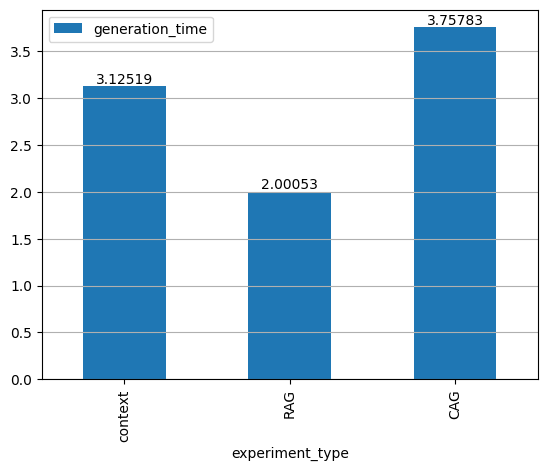

In [19]:
ax = df_stats.plot.bar(x="experiment_type", y="generation_time")
ax.bar_label(ax.containers[0])
plt.grid(axis="y")

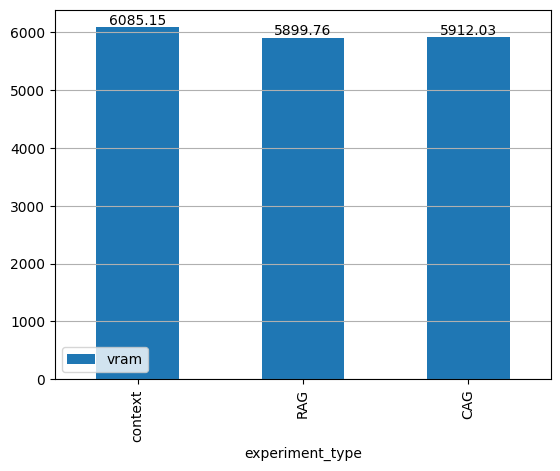

In [20]:
ax = df_stats.plot.bar(x="experiment_type", y="vram")
ax.bar_label(ax.containers[0])
plt.grid(axis="y")